# Traffic4cast 2021 Metrics

![t4c20logo](../t4c20logo.png)

**About:**
In this notebook, we explore mse in two naive baselines.

**Caveat:**
In order to make the module imports work properly set `PYTHONPATH=$PWD` before launching the notebook server from the repo root folder.

In [1]:
import glob
import random
import re
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.nn.functional import mse_loss as torch_mse
import tqdm
from IPython.core.display import display
from IPython.core.display import HTML

from baselines.naive_average import NaiveAverage
from baselines.naive_repeat_last import NaiveRepeatLast
from competition.prepare_test_data.prepare_test_data import prepare_test
from data.data_layout import channel_labels
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from metrics.masking import get_static_mask
from metrics.mse import mse
from metrics.visualization import animate
from metrics.visualization import plot_prediction
from util.check_data_raw_dir import check_raw_data_dir
from util.h5_util import load_h5_file

In [2]:
%load_ext autoreload
%load_ext snakeviz
%load_ext time
%autoreload 2
%autosave 60

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [3]:
BASE_FOLDER = "../data/raw"
check_raw_data_dir(BASE_FOLDER, show_missing=False)

File structure ../data/raw:  (✓)


# The metric

Like last year, our core competition will keep to simple MSE, even though we are in full knowledge that this metric is crude at best.
The hunt for a better metric still excites us and we started exploring options like masking etc. in this notebook as well as in the forum.


## Exploring full picture mse on two naive baselines
Let's test two naive baselines on some training data. We see that the naively repeating the last frame gives more squared
error in areas with sparse data than taking the average from the test period.

In [4]:
training_files = glob.glob(f"{BASE_FOLDER}/ISTANBUL/training/*8ch.h5")
print(f"Found {len(training_files)} training files, e.g. {training_files[0]}")

Found 180 training files, e.g. ../data/raw/ISTANBUL/training/2019-05-12_ISTANBUL_8ch.h5


In [5]:
data = load_h5_file(training_files[0])
test_data, ground_truth_prediction = prepare_test(data, offset=120)
print(f"Data loaded as {type(test_data)} with dtype {test_data.dtype} and shape {test_data.shape}")
print(f"Test data min={np.min(test_data)}, max={np.max(test_data)} and mean={np.mean(test_data)}")
print(f"Ground truth min={np.min(ground_truth_prediction)}, max={np.max(ground_truth_prediction)} and mean={np.mean(ground_truth_prediction)}")

Data loaded as <class 'numpy.ndarray'> with dtype uint8 and shape (12, 495, 436, 8)
Test data min=0, max=255 and mean=1.7129582812065611
Ground truth min=0, max=255 and mean=1.7756813162203071


### Repeat last frame
The first naive baseline simply takes the last frame of the input data 6 times in the output (see baselines/naive_repeat_last.py)

MSE for predicted 6 frames: 131.31187438964844


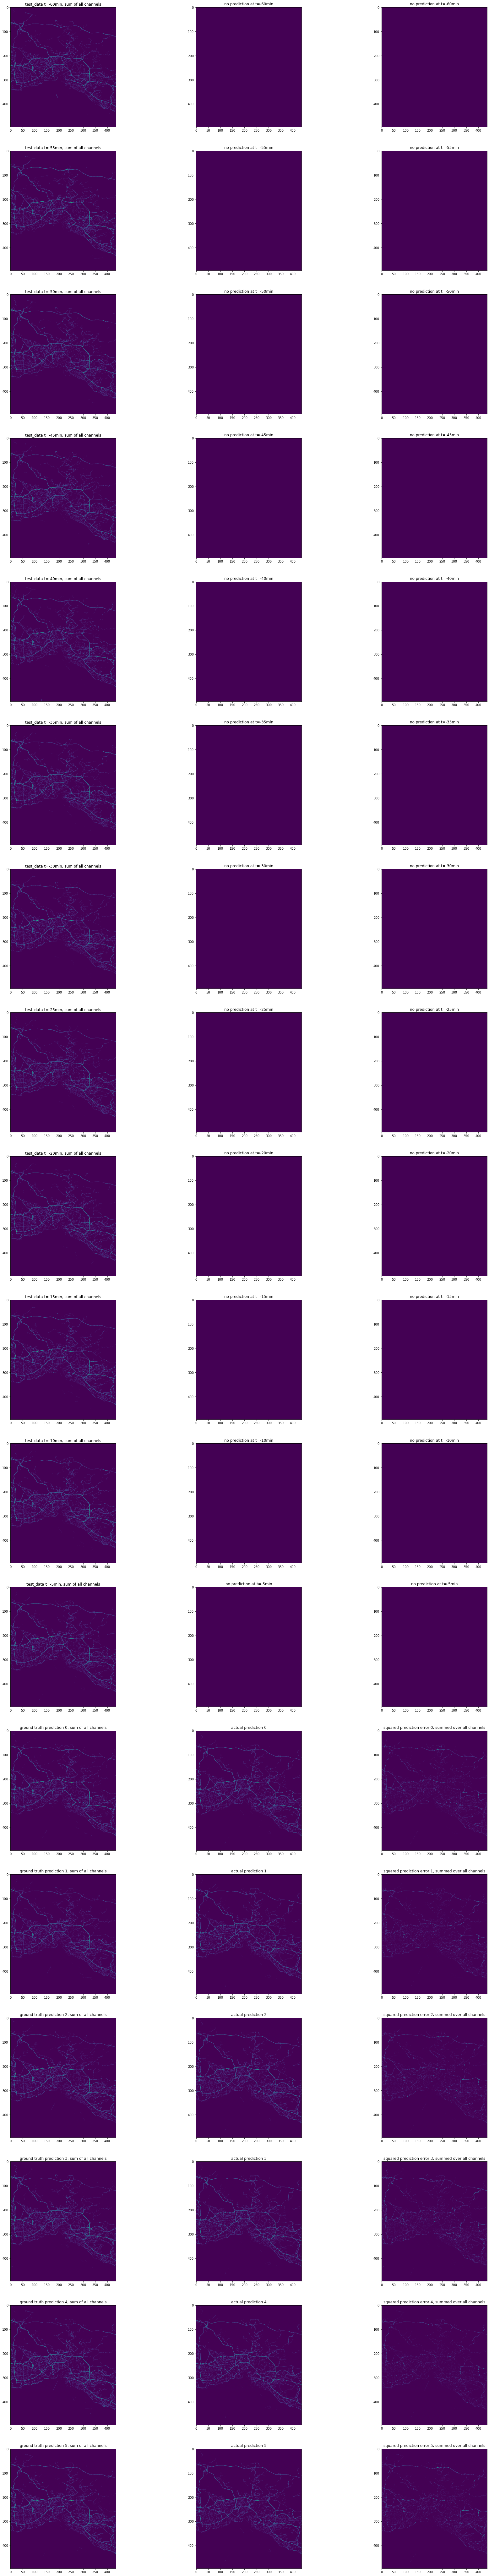

In [6]:
def naive_repeat_last(x: np.ndarray):
    return torch.squeeze(NaiveRepeatLast().forward(torch.unsqueeze(torch.from_numpy(x).float(), dim=0)), dim=0).numpy()


prediction = naive_repeat_last(test_data)
print(f"MSE for predicted 6 frames: {mse(prediction, ground_truth_prediction)}")
plot_prediction(test_data, ground_truth_prediction, prediction)

100%|██████████| 6/6 [00:00<00:00, 421.32it/s]


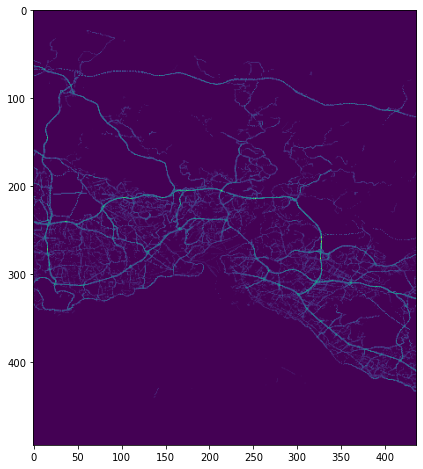

In [7]:
# replay at 1 frame per 1000ms
animate(np.sum(ground_truth_prediction, axis=-1), interval=1000, replay_delay=2000)

100%|██████████| 6/6 [00:00<00:00, 808.10it/s]


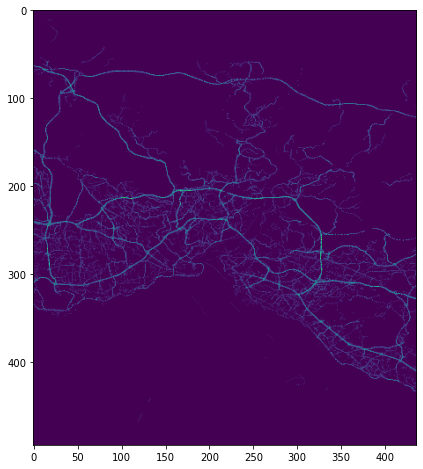

In [8]:
animate(np.sum(prediction, axis=-1), interval=1000, replay_delay=2000)

### Average frames

If we average the frames, we see a lower mse because the train_model is less wrong in the average
than by just repeating the last frame where it is often plainly wrong. How does your train_model behave?

In [9]:
print(test_data.shape)

(12, 495, 436, 8)


MSE for predicted 6 frames: 71.3639907836914


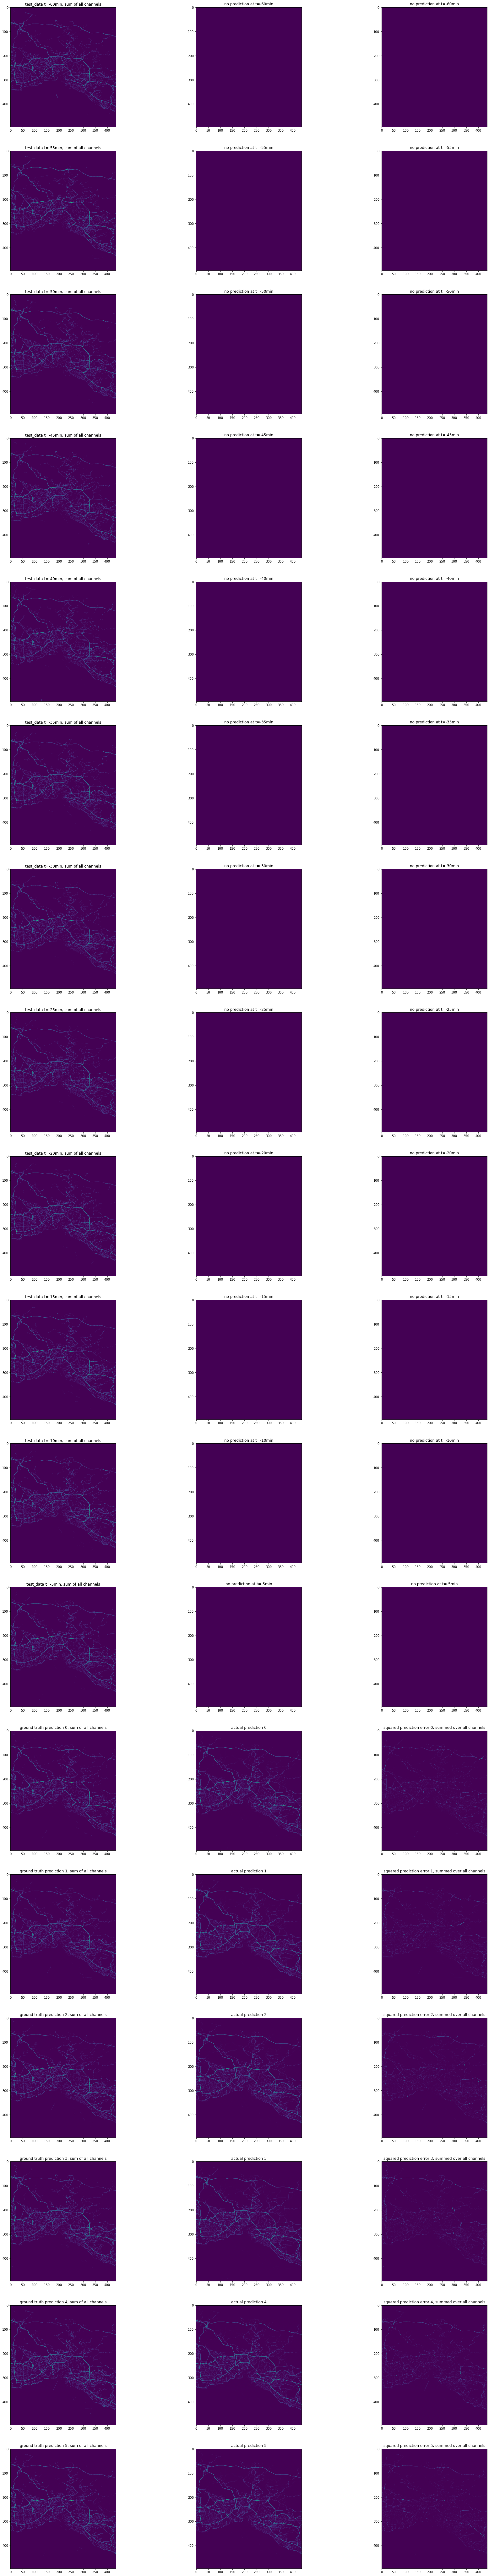

In [10]:
def naive_average(x: np.ndarray):
    return torch.squeeze(NaiveAverage().forward(torch.unsqueeze(torch.from_numpy(x).float(), dim=0)), dim=0).numpy()


prediction = naive_average(test_data)
print(f"MSE for predicted 6 frames: {mse(prediction, ground_truth_prediction)}")
plot_prediction(test_data, ground_truth_prediction, prediction)

100%|██████████| 6/6 [00:00<00:00, 735.48it/s]


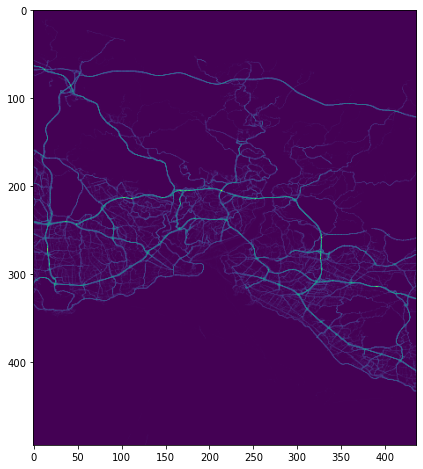

In [11]:
animate(np.sum(prediction, axis=-1))

### Inspecting time of day distribution of mse loss

Let's have a look at daily patterns of mse. We see that we mse in both cases peeks at supposed morning and
afternoon rush hours. We suppose this is due to more variance in the areas of sparse traffic and due to the train_model
not capturing patterns of similar situation. Furthermore, naive averaging over the input hour is far worse than just repeating the last slot.
We suppose this is due to the speed channels where the speed is 0 if there is no data, distorting the average.

In [12]:
training_files = glob.glob(f"{BASE_FOLDER}/**/training/*8ch.h5")
print(f"Found {len(training_files)} training files, e.g. {training_files[0]}")

files_per_city = 3
cities = list({re.search(f"{BASE_FOLDER}/([A-Z]+)/.*", s).group(1) for s in training_files})
cities = cities
print(cities)


def process(arg):
    city, year = arg
    print(f"Processing {year} in {city}")

    static_mask = get_static_mask(city, base_folder=BASE_FOLDER)

    files = glob.glob(f"{BASE_FOLDER}/{city}/training/{year}*.h5", recursive=True)[:files_per_city]
    if len(files) == 0:
        print(f"no training files for {city} {year}")
        return None, None

    mse_naive_repeat_last = 0
    mse_naive_average = 0
    mse_naive_repeat_last_hourly = np.zeros(22)
    mse_naive_average_hourly = np.zeros(22)

    mse_naive_repeat_last_channelwise = np.zeros(8)
    mse_naive_average_channelwise = np.zeros(8)

    mse_naive_repeat_last_horizon = np.zeros(shape=(6, 8))
    mse_naive_average_horizon = np.zeros(shape=(6, 8))
    
    mse_naive_repeat_last_heatmap = np.zeros(shape=(495, 436, 8))
    mse_naive_average_heatmap = np.zeros(shape=(495, 436, 8))
    
    
    mse_masked = 0
    mse_masked_norm = 0

    for f in files:
        data = load_h5_file(f)

        for t in range(22):
            test_data, ground_truth_prediction = prepare_test(data, t * 12)

            # repeat last
            prediction = naive_repeat_last(test_data)
            mse_prediction = mse(prediction, ground_truth_prediction)
            mse_naive_repeat_last += mse_prediction
            mse_naive_repeat_last_hourly[t] += mse_prediction
            mse_naive_repeat_last_channelwise += mse(prediction, ground_truth_prediction, axis=(0, 1, 2))
            for p in range(6):
                mse_naive_repeat_last_horizon[p] += mse(prediction[p], ground_truth_prediction[p], axis=(0, 1))
            mse_naive_repeat_last_heatmap += np.sum((ground_truth_prediction-prediction)**2, axis=0) / 6
            
            # naive averaging
            prediction = naive_average(test_data)
            mse_prediction = mse(prediction, ground_truth_prediction)
            mse_naive_average += mse_prediction
            mse_naive_average_hourly[t] += mse_prediction
            mse_naive_average_channelwise += mse(prediction, ground_truth_prediction, axis=(0, 1, 2))
            for p in range(6):
                mse_naive_average_horizon[p] += mse(prediction[p], ground_truth_prediction[p], axis=(0, 1))
            mse_naive_average_heatmap += np.sum((ground_truth_prediction-prediction)**2, axis=0) / 6

            # mask naive averaging
            mse_masked += mse(prediction, ground_truth_prediction, mask=static_mask, mask_norm=False)
            mse_masked_norm += mse(prediction, ground_truth_prediction, mask=static_mask)
            

    # averaging
    num_days = len(files)
    num_hourly_tests = num_days * 22
    
    mse_naive_repeat_last = mse_naive_repeat_last / num_hourly_tests
    mse_naive_repeat_last_hourly = mse_naive_repeat_last_hourly / num_days
    
    mse_naive_average = mse_naive_average / num_hourly_tests
    mse_naive_average_hourly = mse_naive_average_hourly / num_days
    
    mse_naive_repeat_last_channelwise = mse_naive_repeat_last_channelwise / num_hourly_tests
    mse_naive_average_channelwise = mse_naive_average_channelwise / num_hourly_tests
    
    mse_naive_repeat_last_horizon = mse_naive_repeat_last_horizon / num_hourly_tests
    mse_naive_average_horizon = mse_naive_average_horizon / num_hourly_tests
    
    mse_naive_repeat_last_heatmap = mse_naive_repeat_last_heatmap / num_hourly_tests
    mse_naive_average_heatmap = mse_naive_average_heatmap / num_hourly_tests
    
    mse_masked = mse_masked / num_hourly_tests
    mse_masked_norm = mse_masked_norm / num_hourly_tests

    return (
        (city, year),
        [
            mse_naive_repeat_last,
            mse_naive_repeat_last_hourly,
            mse_naive_repeat_last_channelwise,
            mse_naive_average,
            mse_naive_average_hourly,
            mse_naive_average_channelwise,
            mse_naive_repeat_last_horizon,
            mse_naive_average_horizon,
            mse_naive_repeat_last_heatmap,
            mse_naive_average_heatmap,
            mse_masked,
            mse_masked_norm,
        ],
    )

cities_of_interest = ["BERLIN"]


tasks = [(city, year) for city in cities for year in ["2019-04", "2019-05", "2020-04", "2020-05"] if city in cities_of_interest]

multiprocessing = False
if multiprocessing:
    with Pool(processes=4) as pool:
        output = list(tqdm.tqdm(pool.imap_unordered(process, tasks), total=len(tasks)))
        mse_stats = dict(output)
else:
    output = []
    for task in tasks:
        output.append(process(task))
    mse_stats = dict(output)

Found 2164 training files, e.g. ../data/raw/BARCELONA/training/2020-05-22_BARCELONA_8ch.h5
['ANTWERP', 'MELBOURNE', 'BERLIN', 'MOSCOW', 'CHICAGO', 'ISTANBUL', 'BARCELONA', 'BANGKOK']
Processing 2019-04 in BERLIN
Processing 2019-05 in BERLIN
Processing 2020-04 in BERLIN
no training files for BERLIN 2020-04
Processing 2020-05 in BERLIN
no training files for BERLIN 2020-05


In [13]:
if None in mse_stats:
    del mse_stats[None]

BERLIN 2019-04
mse_naive_repeat_last         166.56665
mse_naive_average              93.78066
mse_masked                     93.15563
mse_masked_norm               158.86504


<ipython-input-14-cf1eeb28c581>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])
<ipython-input-14-cf1eeb28c581>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])


BERLIN 2019-05
mse_naive_repeat_last         170.12344
mse_naive_average              95.63425
mse_masked                     95.04936
mse_masked_norm               162.09455


<ipython-input-14-cf1eeb28c581>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])
<ipython-input-14-cf1eeb28c581>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])


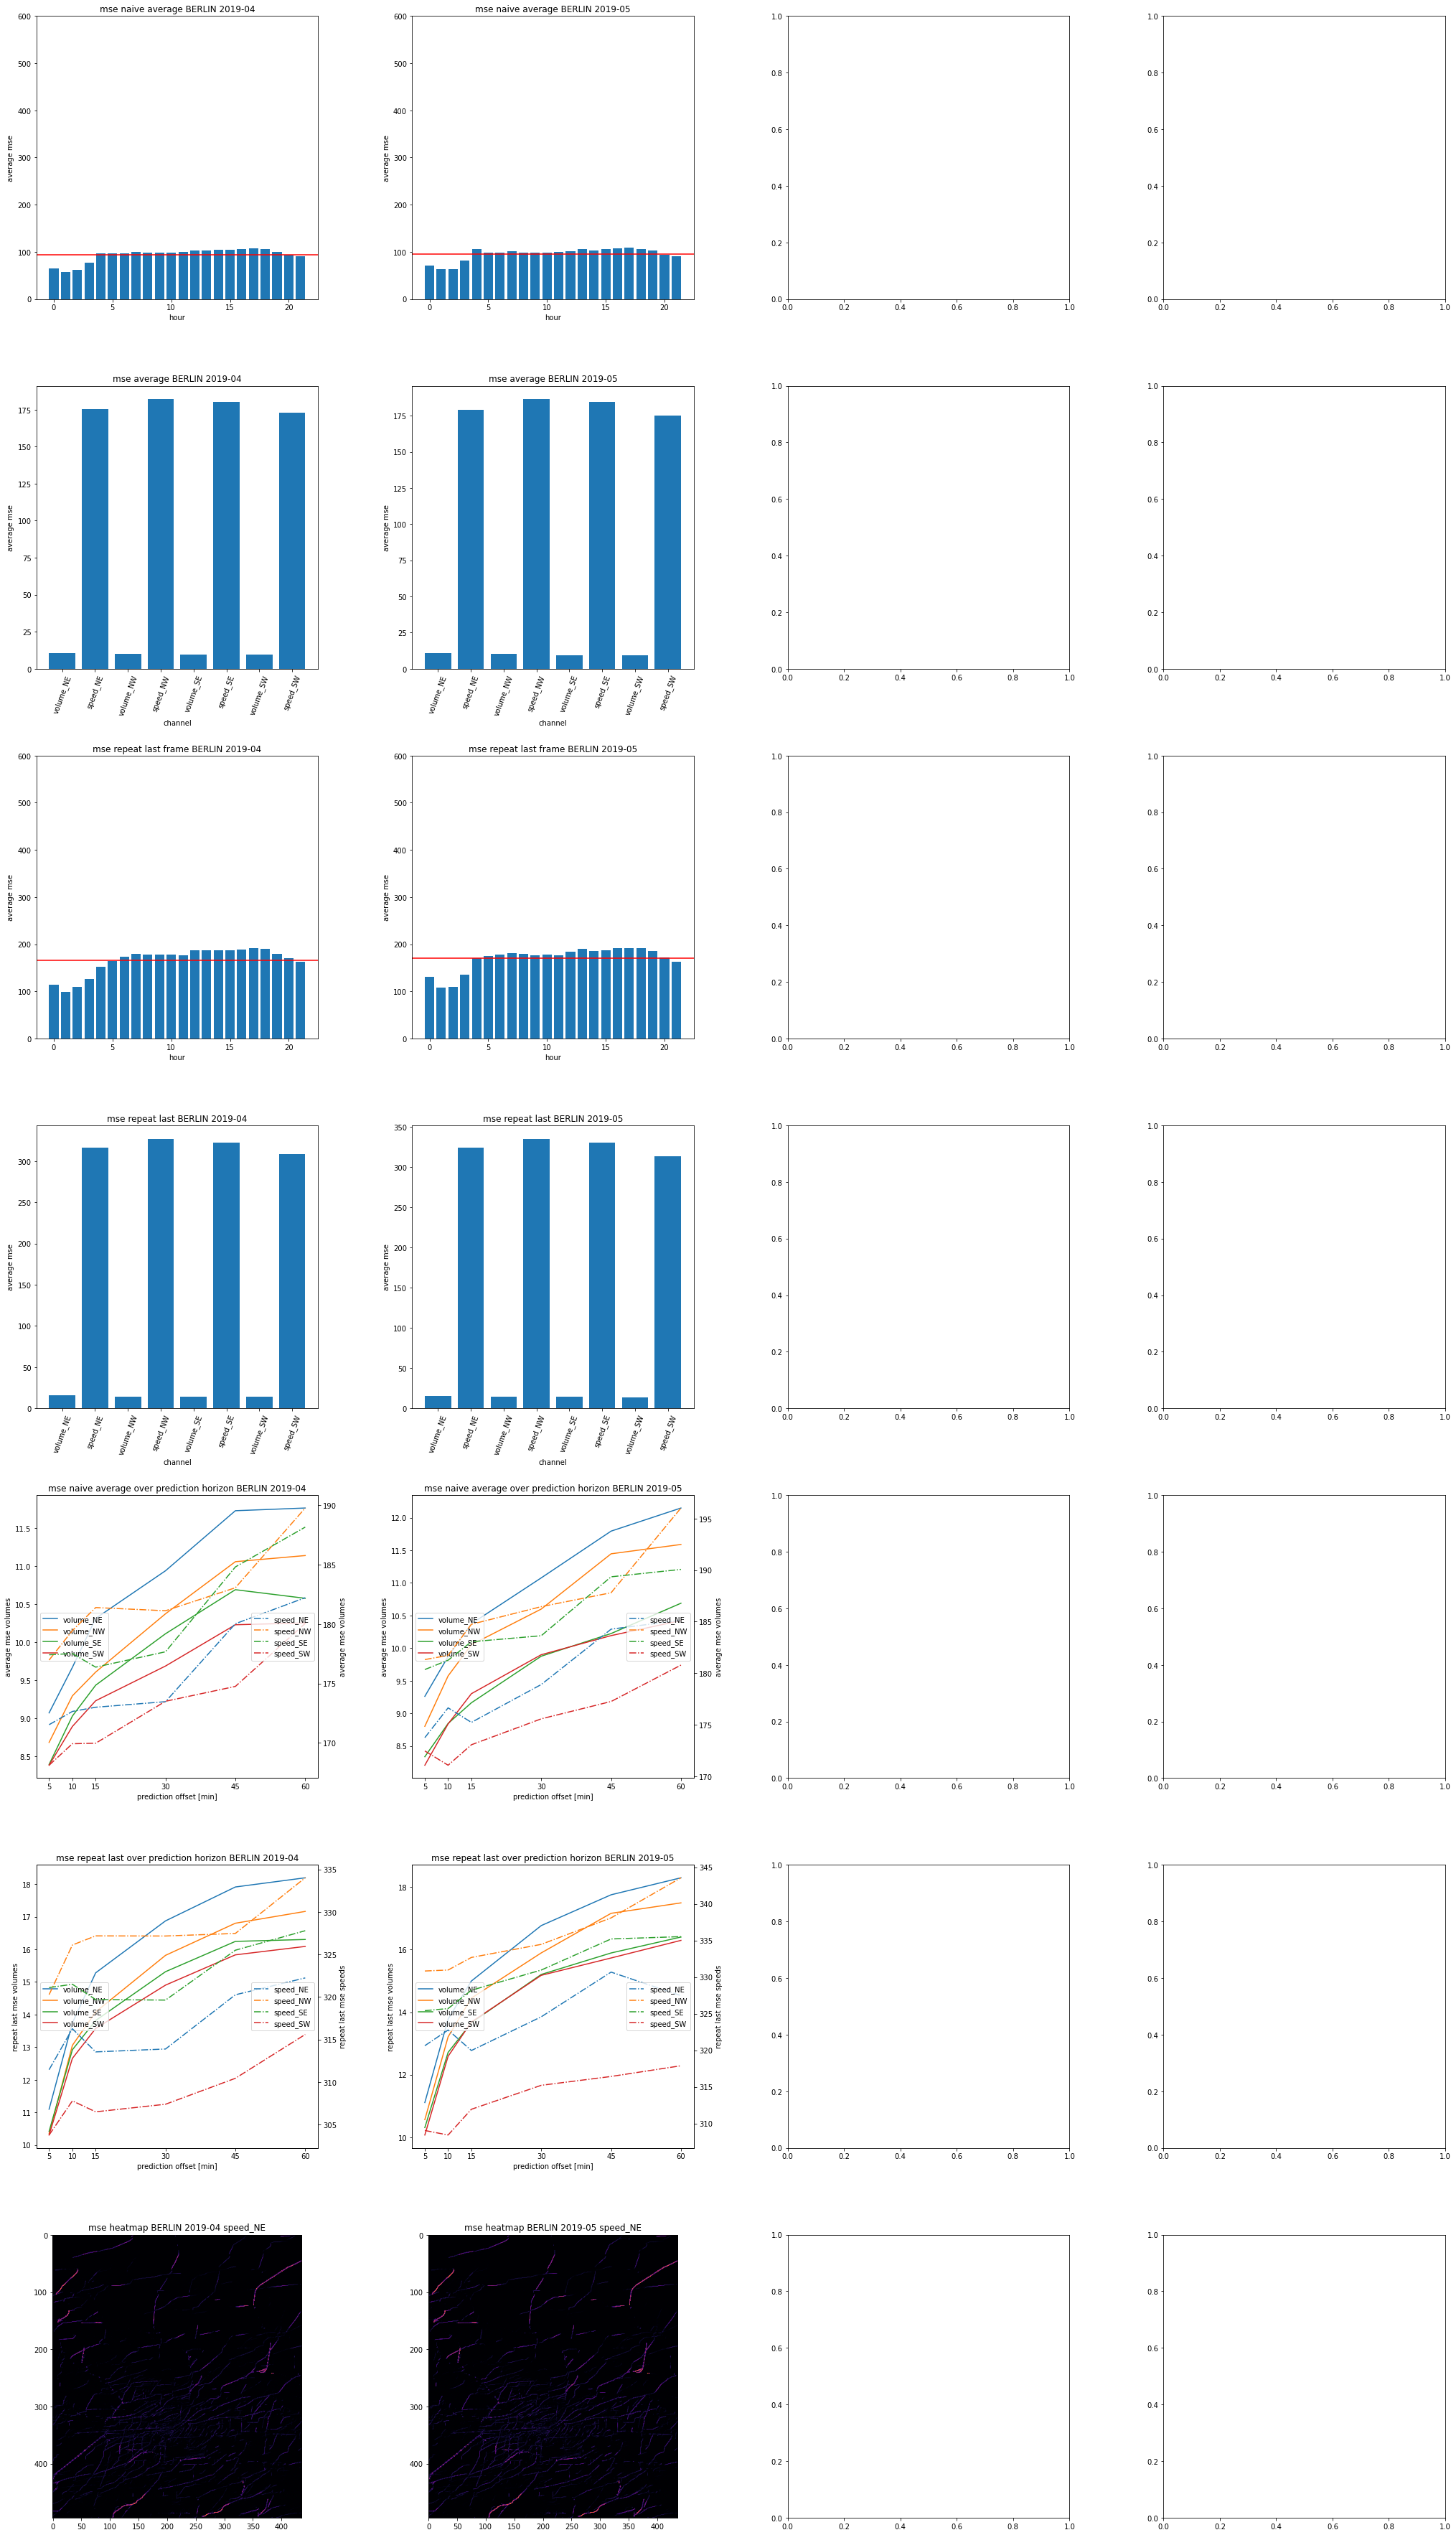

In [14]:
def plot_daily_distribution(y, mean, title, ax=plt):
    ax.bar(np.arange(22), y)
    ax.set_xlabel("hour")
    ax.set_ylabel("average mse")
    ax.axhline(y=mean, color="r", linestyle="-")
    if ax == plt:
        plt.title(title)
        plt.show()
    else:
        ax.set_title(title)


for city in list({c for c, _ in mse_stats}):
    if city not in cities_of_interest:
        continue
    years = ["2019-04", "2019-05", "2020-04", "2020-05"]
    cols = len(years)
    rows = 7
    scale_factor = 7
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale_factor, rows * scale_factor))
    fig.tight_layout(h_pad=10, w_pad=10)

    static = load_h5_file(f"{BASE_FOLDER}/{city}/{city}_map_high_res.h5")

    for k, year in enumerate(years):
        if (city, year) not in mse_stats:
            continue
        ax = axs[0, k]
        (
            mse_naive_repeat_last,
            mse_naive_repeat_last_hourly,
            mse_naive_repeat_last_channelwise,
            mse_naive_average,
            mse_naive_average_hourly,
            mse_naive_average_channelwise,
            mse_naive_repeat_last_horizon,
            mse_naive_average_horizon,
            mse_naive_repeat_last_heatmap,
            mse_naive_average_heatmap,
            mse_masked,
            mse_masked_norm,
        ) = mse_stats[(city, year)]

        print(f"{city} {year}")
        print(f"mse_naive_repeat_last  {mse_naive_repeat_last: >#016.5f}")
        print(f"mse_naive_average      {mse_naive_average: >#016.5f}")
        print(f"mse_masked             {mse_masked: >#016.5f}")
        print(f"mse_masked_norm        {mse_masked_norm: >#016.5f}")



        plot_daily_distribution(mse_naive_average_hourly, mse_naive_average, f"mse naive average {city} {year}", ax=ax)
        ax.set_ylim([0, 600])

        ax = axs[1, k]
        ax.set_title(f"mse average {city} {year}")
        ax.bar(np.arange(8), mse_naive_average_channelwise)
        ax.set_xlabel("channel")
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels(channel_labels[:8], rotation=70)
        ax.set_ylabel("average mse")

        ax = axs[2, k]
        plot_daily_distribution(mse_naive_repeat_last_hourly, mse_naive_repeat_last, f"mse repeat last frame {city} {year}", ax=ax)
        ax.set_ylim([0, 600])

        ax = axs[3, k]
        ax.set_title(f"mse repeat last {city} {year}")
        ax.bar(np.arange(8), mse_naive_repeat_last_channelwise)
        ax.set_xlabel("channel")
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels(channel_labels[:8], rotation=70)
        ax.set_ylabel("average mse")

        ax = axs[4, k]
        ax.set_title(f"mse naive average over prediction horizon {city} {year}")
        for ch in [0,2,4,6]:
            ax.plot([5,10,15,30,45,60], mse_naive_average_horizon[:,ch], label=channel_labels[ch])
        ax2 = ax.twinx()
        for ch in [1,3,5,7]:
            ax2.plot([5,10,15,30,45,60], mse_naive_average_horizon[:,ch], label=channel_labels[ch], linestyle="-.")


        ax.legend(loc="center left")
        ax2.legend(loc="center right")
        ax.set_xlabel("prediction offset [min]")
        ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])
        ax.set_xticks([5,10,15,30,45,60])
        ax.set_ylabel("average mse volumes")
        ax2.set_ylabel("average mse volumes")

        ax = axs[5, k]
        ax.set_title(f"mse repeat last over prediction horizon {city} {year}")
        for ch in [0,2,4,6]:
            ax.plot([5,10,15,30,45,60], mse_naive_repeat_last_horizon[:,ch], label=channel_labels[ch])
        ax2 = ax.twinx()
        for ch in [1,3,5,7]:
            ax2.plot([5,10,15,30,45,60], mse_naive_repeat_last_horizon[:,ch], label=channel_labels[ch], linestyle="-.")
        ax2.legend(loc="center right")
        ax.legend(loc="center left")

        ax.set_xlabel("prediction offset [min]")
        ax.set_xticklabels(["5", "10", "15", "30", "45", "60"])
        ax.set_xticks([5,10,15,30,45,60])
        ax.set_ylabel("repeat last mse volumes")
        ax2.set_ylabel("repeat last mse speeds")
        
        ax = axs[6, k]
        ch = 1
        ax.set_title(f"mse heatmap {city} {year} {channel_labels[ch]}")
        ax.imshow(mse_naive_repeat_last_heatmap[:,:,ch], cmap="inferno")


    plt.show(fig)

<ipython-input-15-f1f6fa1337fe>:38: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)
<ipython-input-15-f1f6fa1337fe>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(c-num,c+num))
<ipython-input-15-f1f6fa1337fe>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(r-num,r+num))
<ipython-input-15-f1f6fa1337fe>:59: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)
<ipython-input-15-f1f6fa1337fe>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(c-num,c+num))
<ipython-input-15-f1f6fa1337fe>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(r-num,r+num))


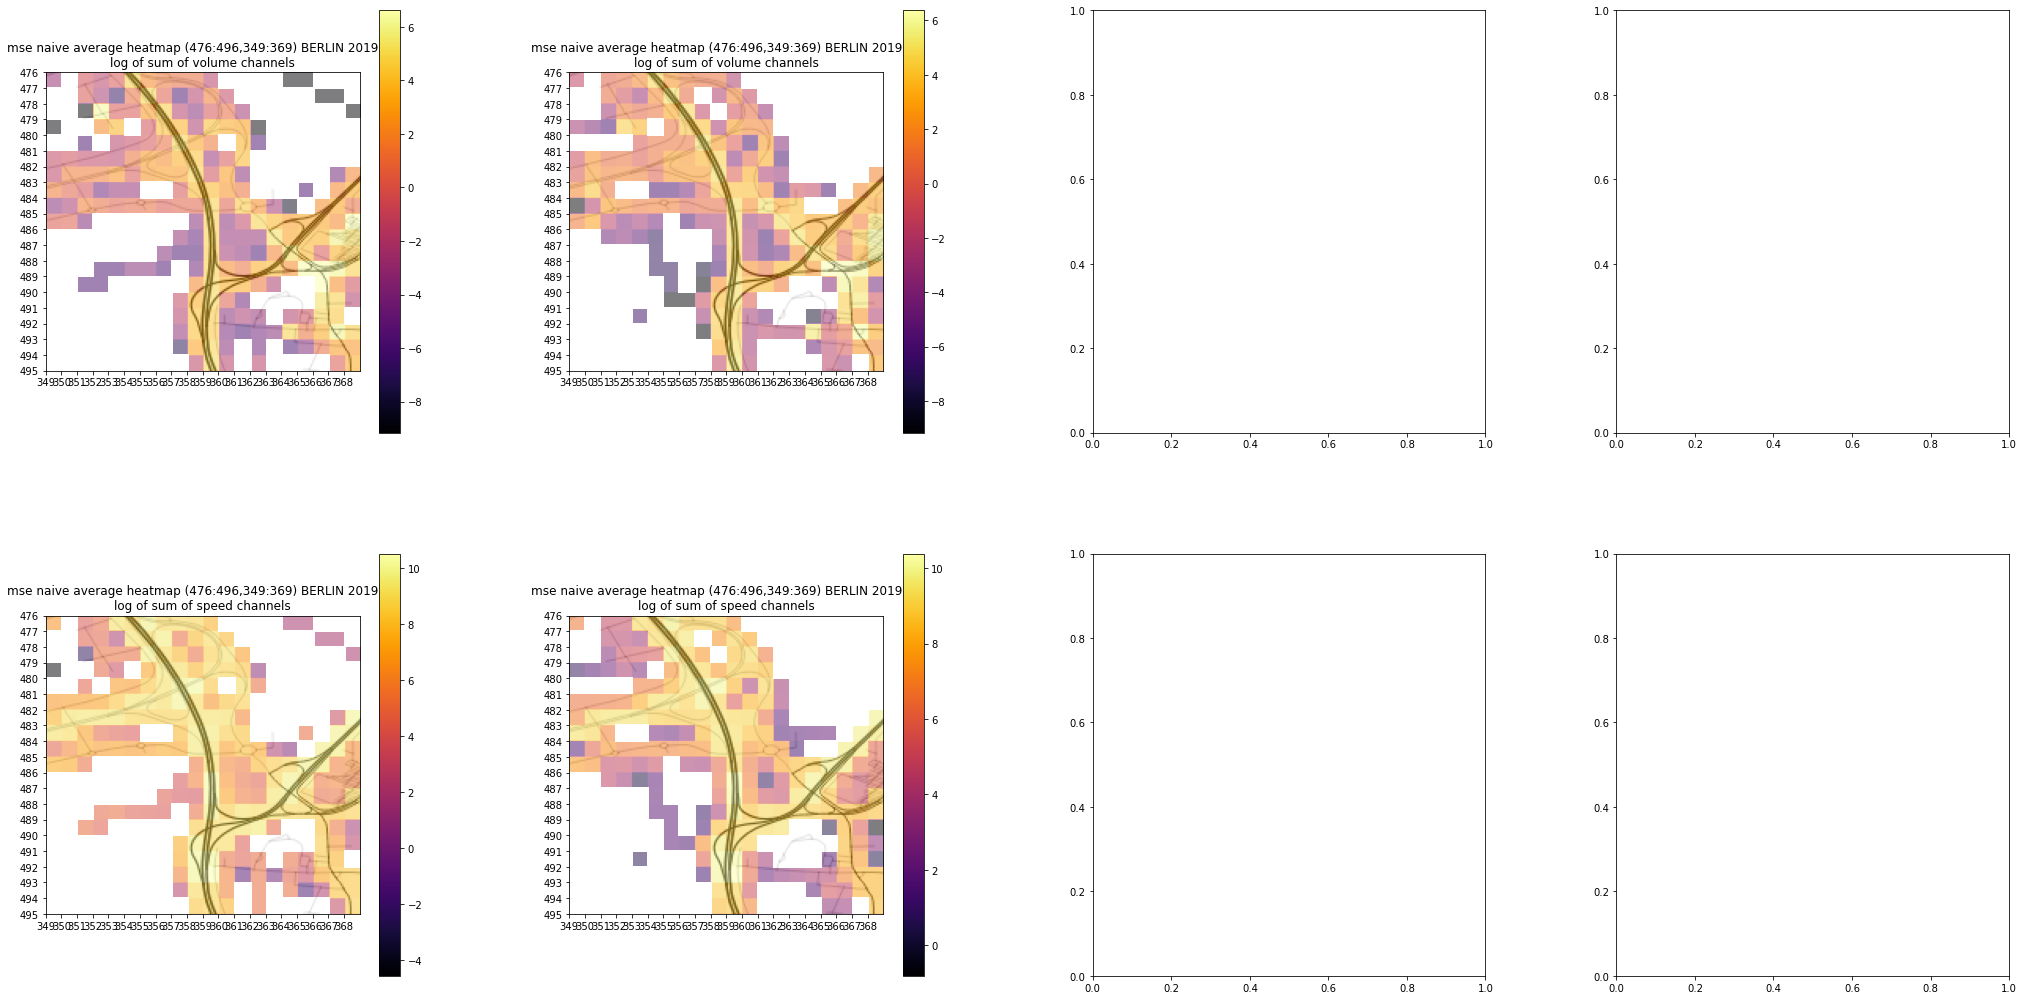

In [15]:
for city in list({c for c, _ in mse_stats}):
    if city not in cities_of_interest:
        continue
    years = ["2019-04", "2019-05", "2020-04", "2020-05"]
    cols = len(years)
    rows = 2
    scale_factor = 7
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale_factor, rows * scale_factor))
    fig.tight_layout(h_pad=10, w_pad=10)

    static = load_h5_file(f"{BASE_FOLDER}/{city}/{city}_map_high_res.h5")

    for k, year in enumerate(years):
        if (city, year) not in mse_stats:
            continue
        ax = axs[0, k]
        (
            mse_naive_repeat_last,
            mse_naive_repeat_last_hourly,
            mse_naive_repeat_last_channelwise,
            mse_naive_average,
            mse_naive_average_hourly,
            mse_naive_average_channelwise,
            mse_naive_repeat_last_horizon,
            mse_naive_average_horizon,
            mse_naive_repeat_last_heatmap,
            mse_naive_average_heatmap,
            mse_masked,
            mse_masked_norm,
        ) = mse_stats[(city, year)]

        r = 486
        c = 359
        num = 10
        ax = axs[0, k]
        ax.set_title(f"mse naive average heatmap ({r-num}:{r+num},{c-num}:{c+num}) {city} {year}\nlog of sum of volume channels")
        data = mse_naive_average_heatmap[:,:,0] + mse_naive_average_heatmap[:,:,2] + mse_naive_average_heatmap[:,:,4] + mse_naive_average_heatmap[:,:,6]
        data = np.log(data)

        # blow-up 10m->100m
        blup = np.zeros(shape=(2*10*num,2*10*num))
        for i in range(-10*num,10*num):
            for j in range(-10*num,10*num):
                if r+i//10 >= 495 or c+j//10 >= 436:
                    continue
                blup[i+10*num,j+10*num]=data[r+i//10,c+j//10]
        im = ax.imshow(blup, cmap="inferno")
        fig.colorbar(im, ax=ax)

        ax.imshow(static[10*(r-num):10*(r+num),10*(c-num):10*(c+num)],cmap='gray_r', alpha=0.5, vmin=0,vmax=255)
        ax.set_xticklabels(np.arange(c-num,c+num))
        ax.set_xticks(np.arange(-0.5, 2 * num * 10 - 0.5, 10))
        ax.set_yticklabels(np.arange(r-num,r+num))
        ax.set_yticks(np.arange(-0.5, 2 * num * 10 - 0.5, 10))

        ax = axs[1, k]
        ax.set_title(f"mse naive average heatmap ({r-num}:{r+num},{c-num}:{c+num}) {city} {year}\nlog of sum of speed channels")
        data = mse_naive_average_heatmap[:,:,1] + mse_naive_average_heatmap[:,:,3] + mse_naive_average_heatmap[:,:,5] + mse_naive_average_heatmap[:,:,7]
        data = np.log(data)
        # blow-up 10m->100m
        blup = np.zeros(shape=(2*10*num,2*10*num))
        for i in range(-10*num,10*num):
            for j in range(-10*num,10*num):
                if r+i//10 >= 495 or c+j//10 >= 436:
                    continue
                blup[i+10*num,j+10*num]=data[r+i//10,c+j//10]
        im = ax.imshow(blup, cmap="inferno")
        fig.colorbar(im, ax=ax)

        ax.imshow(static[10*(r-num):10*(r+num),10*(c-num):10*(c+num)],cmap='gray_r', alpha=0.5, vmin=0,vmax=255)
        ax.set_xticklabels(np.arange(c-num,c+num))
        ax.set_xticks(np.arange(-0.5, 2 * num * 10 - 0.5, 10))
        ax.set_yticklabels(np.arange(r-num,r+num))
        ax.set_yticks(np.arange(-0.5, 2 * num * 10 - 0.5, 10))


    plt.show(fig)

## Exploring MSE differences through masking

Let's have a look at the general MSE in the different cities and how much of the prediction error happens outside of the road network. The mask is a simple binary mask selecting all cells that are intersected by a road. We're using again the naive average baseline and do then generate a 'graph only' prediction on 2019 data by setting all values outside the mask to zero. This would simulate the output of a purely graph based solution.

In [ ]:
def naive_average(x: np.ndarray):
    return torch.squeeze(NaiveAverage().forward(torch.unsqueeze(torch.from_numpy(x).float(), dim=0)), dim=0).numpy()


def get_mse_scores(city, offsets, num_files=5):
    mask = get_static_mask(city, base_folder=BASE_FOLDER)
    files = random.sample(sorted(glob.glob(f"{BASE_FOLDER}/{city}/training/2019*8ch.h5")), num_files)
    count = 0
    normal_mse = 0.0
    masked_mse = 0.0
    graph_mse = 0.0
    for f in files:
        data = load_h5_file(f)
        for offset in offsets:
            test_data, ground_truth = prepare_test(data, offset)
            prediction = naive_average(test_data)
            normal_mse += mse(prediction, ground_truth)
            masked_mse += mse(prediction*mask, ground_truth*mask)
            graph_mse += mse(prediction*mask, ground_truth)
            count += 1
    normal_mse /= count
    masked_mse /= count
    graph_mse /= count
    return {
        'city': city, 'full mse': normal_mse,
        'both masked': masked_mse, 'diff both masked': normal_mse-masked_mse,
        'graph only': graph_mse, 'diff graph only': normal_mse-graph_mse,
        'test slots': count
    }


scores = []
for city in ['ISTANBUL', 'BERLIN', 'MELBOURNE', 'CHICAGO']:
    scores.append(get_mse_scores(city, offsets=[50, 72, 86, 98, 120, 134, 156, 188, 212, 238]))

df = pd.DataFrame(scores)

df.append({
    'city': 'ALL', 'full mse': df['full mse'].mean(),
    'both masked': df['both masked'].mean(), 'diff both masked': df['diff both masked'].mean(),
    'graph only': df['graph only'].mean(), 'diff graph only': df['diff graph only'].mean(),
    'test slots': df['test slots'].sum()
}, ignore_index=True)

Unsurprisingly, Istanbul has the highest rate and one possible explanation is the large amount of water ways with commerical boat traffic in the area. Hence, let's have a look at the differences on the map.

In [ ]:
def get_example_frame(city, msg, channels=None, offset=120):
    print(f'Loading {msg} for {city}')
    mask = get_static_mask(city, base_folder=BASE_FOLDER)
    f = random.sample(sorted(glob.glob(f"{BASE_FOLDER}/{city}/training/2019*8ch.h5")), 1)[0]
    print(f)
    data = load_h5_file(f)
    test_data, ground_truth = prepare_test(data, offset)
    prediction = naive_average(test_data)
    print(f'full MSE for example slot at 10am: {mse(prediction, ground_truth)}')
    print(f'mask MSE for example slot at 10am: {mse(prediction*mask, ground_truth)}')
    if not channels is None:
        prediction = prediction[...,channels]
        ground_truth = ground_truth[...,channels]
    pr = prediction.astype(float).mean(axis=(0,-1))
    gt = ground_truth.astype(float).mean(axis=(0,-1))
    pe = ((prediction - ground_truth) ** 2).mean(axis=(0,-1))
    mask = mask[...,0]
    pm = pr*mask
    pem = ((pm - gt) ** 2)
    peom = pe * (1-mask)
    print(f'Total prediction error contains {np.count_nonzero(pe)} non-null pixels of which '
          f'{np.count_nonzero(peom)} are outside the masked area')
    return pr, gt, pe, pm, pem, peom, mask, msg


def cmap_lightgrey(num=100):
    cmap = plt.get_cmap('Greys')
    colors = [cmap(i) for i in range(cmap.N)]
    colors = colors[:num]
    return LinearSegmentedColormap.from_list('lightgrey', colors, N=len(colors))


def plot_masking_diffs(pr, gt, pe, pm, pem, peom, mask, msg):
    _, axs = plt.subplots(2, 3, figsize=(20, 15))
    axs[0, 0].set_title(f"actual prediction ({msg})")
    axs[0, 0].imshow(pr, cmap='Greys')
    axs[0, 1].set_title(f"ground truth ({msg})")
    axs[0, 1].imshow(gt, cmap='Greys')
    axs[0, 2].set_title(f"prediction error ({msg})")
    axs[0, 2].imshow(pe, cmap='Greys')
    axs[1, 0].set_title(f"mask of road network")
    axs[1, 0].imshow(mask, cmap='Greys')
    axs[1, 1].set_title(f"errors outside mask (log color scale)")
    axs[1, 1].imshow(peom, cmap=cmap_lightgrey(), norm=LogNorm())
    axs[1, 2].set_title(f"all errors > 0 (grey) vs errors outside mask > 0 (red)")
    axs[1, 2].set_xlabel("error")
    axs[1, 2].set_ylabel("pixel count")
    axs[1, 2].hist(pe[np.nonzero(pe > 0)], range(0,250,1), color='lightgrey')
    axs[1, 2].hist(peom[np.nonzero(peom > 0)], range(0,250,1), color='red')
    plt.show()


plot_masking_diffs(*get_example_frame('ISTANBUL', 'mean of all channels'))
plot_masking_diffs(*get_example_frame('BERLIN', 'mean of all channels'))
# plot_masking_diffs(*get_example_frame('ISTANBUL', 'mean of all volumes', [0,2,4,6]))
plot_masking_diffs(*get_example_frame('CHICAGO', 'mean of all channels'))

## Fundamental diagram for test slots and prediction

In [18]:
def plot_fundamental_diagram(ax, data, row, col, color="blue", label=None):
    x = data[:, row, col, 0]
    y = data[:, row, col, 1]
    filtering = x > 0
    x_filtered = x[filtering]
    y_filtered = y[filtering]

    linear_model = np.polyfit(x_filtered, y_filtered, 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s = np.arange(0, max(x))

    ax.plot(x_s, linear_model_fn(x_s), color=color, label=label)
    ax.scatter(x, y, color=color)
    ax.set_ylim([0,255])
    ax.set_xlim([0,255])
    ax.legend()
    ax.set_ylabel("speed [km/h]", color="steelblue", size=22)
    ax.set_xlabel("volume [%]", color="steelblue", size=22)


    ylp1 = [0.0, 125.0, 255.0]
    yln1 = ["0", "60", "120"]
    ax.set_yticks(ylp1)
    ax.set_yticklabels(yln1)

    y_min, y_max = ax.get_xlim()
    ylp2 = [y_min, y_max / 2, y_max]
    yln2 = ["0", "50", "100"]
    ax.set_xticks(ylp2)
    ax.set_xticklabels(yln2)
    ax.tick_params(axis="x", colors="steelblue", labelsize=22)
    ax.tick_params(axis="y", colors="steelblue", labelsize=22)


def plot_fundamental_diagram_with_ground_truth(data,ground_truth, row,col, title):
    fig, axs = plt.subplots(figsize=(30,10))
    plot_fundamental_diagram(axs, data, row, col, "blue", "prediction distribution")
    plot_fundamental_diagram(axs, ground_truth, row, col, "red", "ground truth distribution")
    axs.set_title(f"{title} ({row},{col})")

In [19]:
city = "BERLIN"
competition = "temporal"
test_slots = load_h5_file(Path(BASE_FOLDER) / city / f"{city}_test_{competition}.h5")

In [20]:
naive_average_prediction = NaiveAverage().forward(torch.from_numpy(test_slots).float()).numpy()

In [21]:
naive_repeat_last_prediction = NaiveRepeatLast().forward(torch.from_numpy(test_slots).float()).numpy()

In [22]:
print(test_slots.shape)
print(naive_average_prediction.shape)
print(naive_repeat_last_prediction.shape)

(100, 12, 495, 436, 8)
(100, 6, 495, 436, 8)
(100, 6, 495, 436, 8)


In [23]:
test_slots = test_slots.reshape(100*12,495,436,8)

In [24]:
naive_average_prediction = naive_average_prediction.reshape(100*6,495,436,8)

In [25]:
naive_repeat_last_prediction = naive_repeat_last_prediction.reshape(100*6,495,436,8)

In [26]:
# load a submission:
# with zipfile.ZipFile(f'../submission_..._{competition}_2021....zip') as myzip:
#     with myzip.open(f'{city}/{city}_test_{competition}.h5') as myfile:
#         prediction = load_h5_file(myfile)
# prediction = prediction.reshape(100*6,495,436,8)

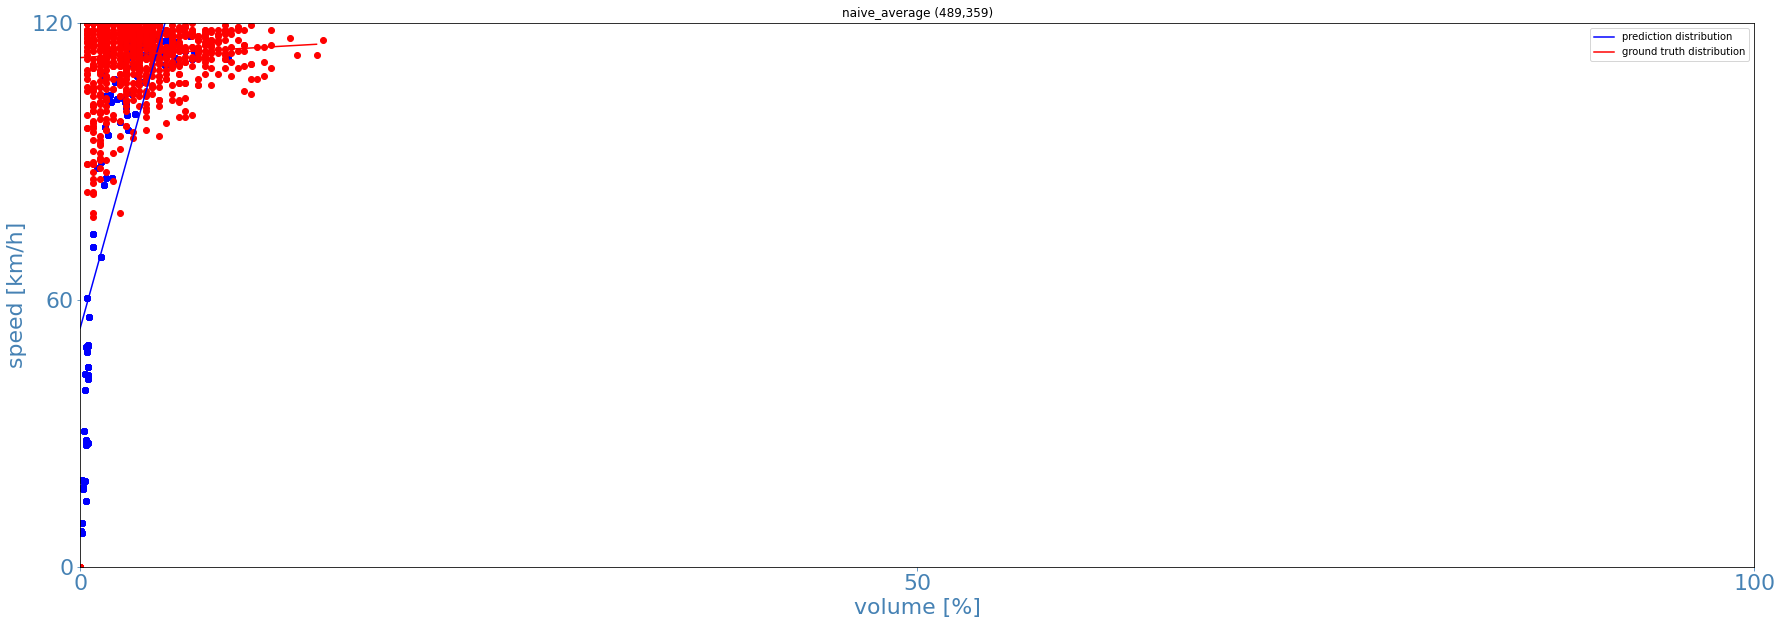

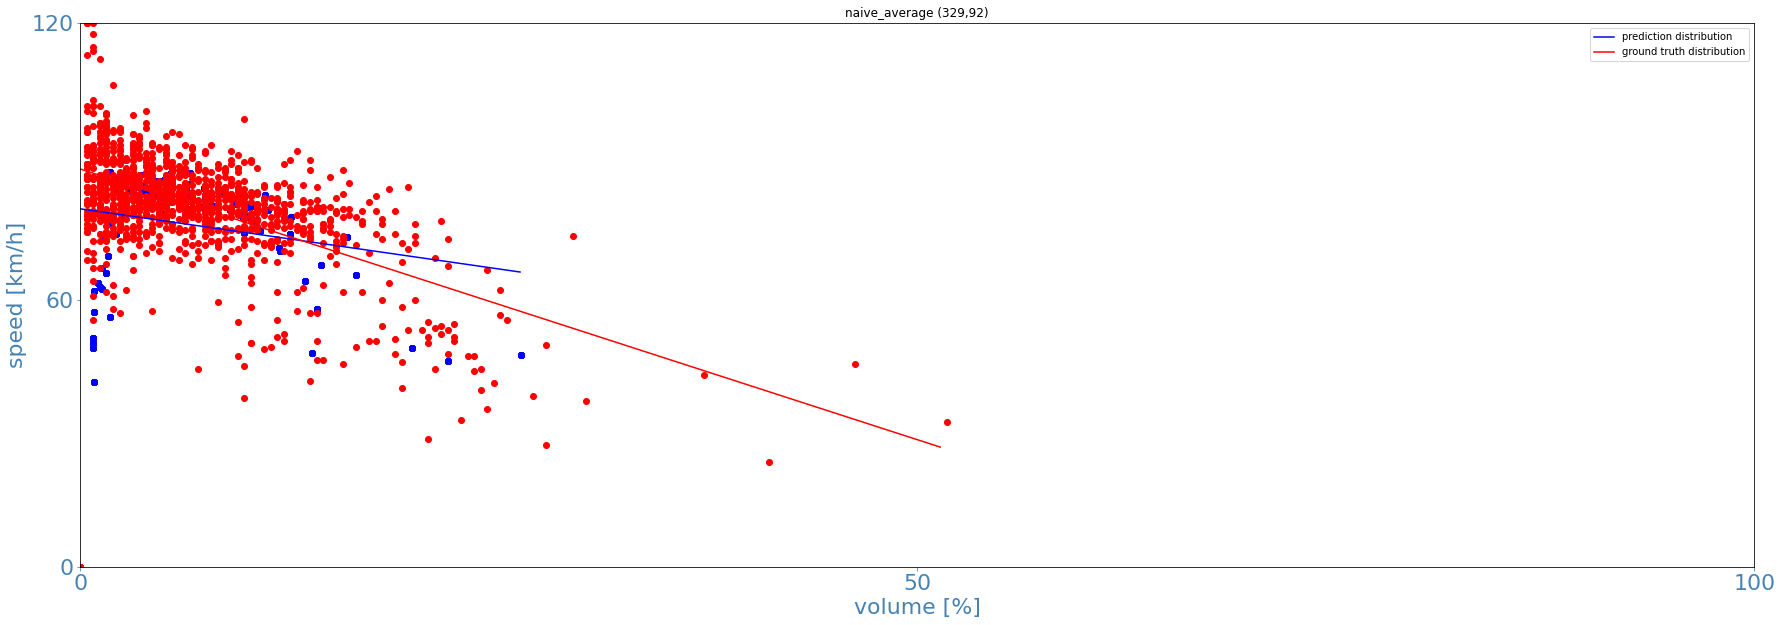

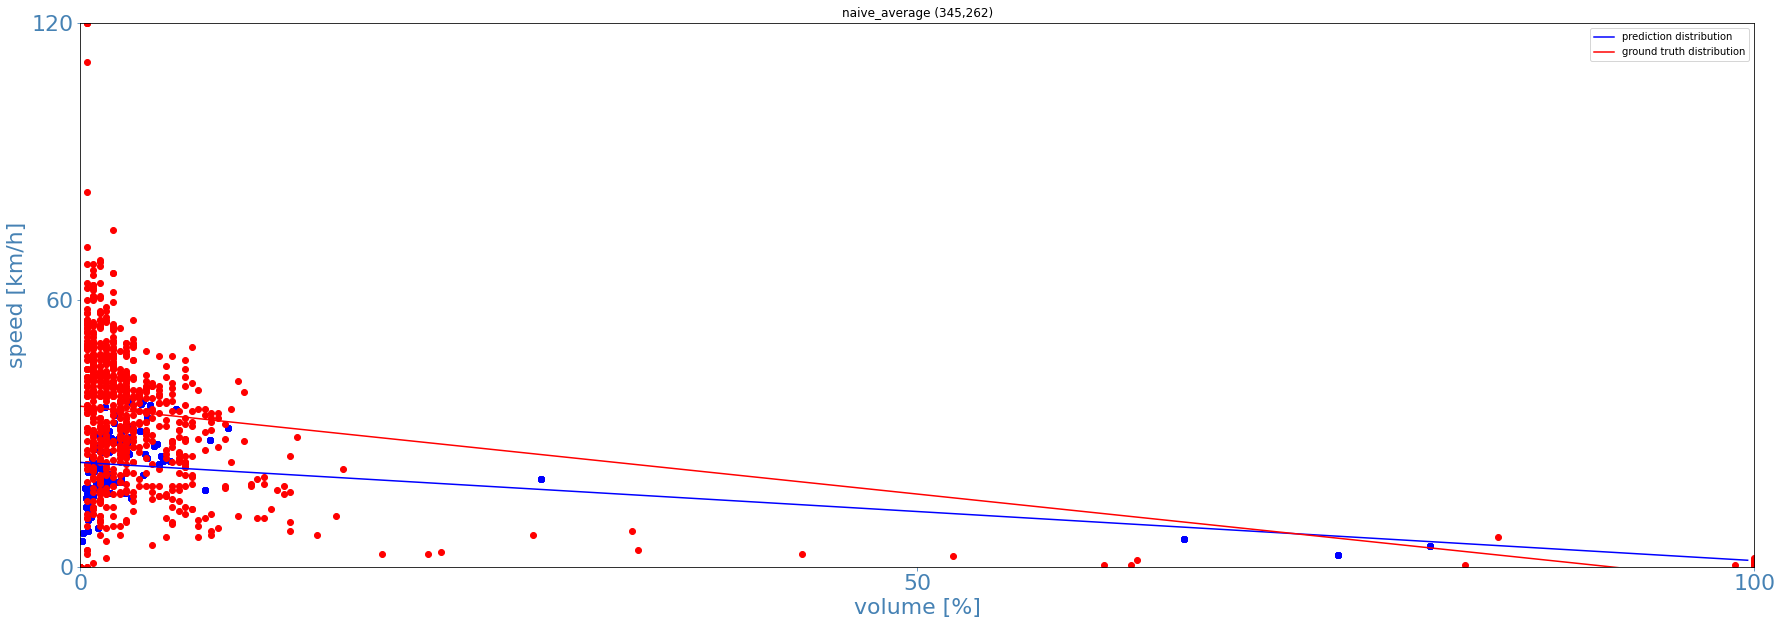

In [27]:
plot_fundamental_diagram_with_ground_truth(naive_average_prediction,test_slots, 489, 359, "naive_average")
plot_fundamental_diagram_with_ground_truth(naive_average_prediction,test_slots, 329, 92, "naive_average")
plot_fundamental_diagram_with_ground_truth(naive_average_prediction,test_slots, 345, 262, "naive_average")

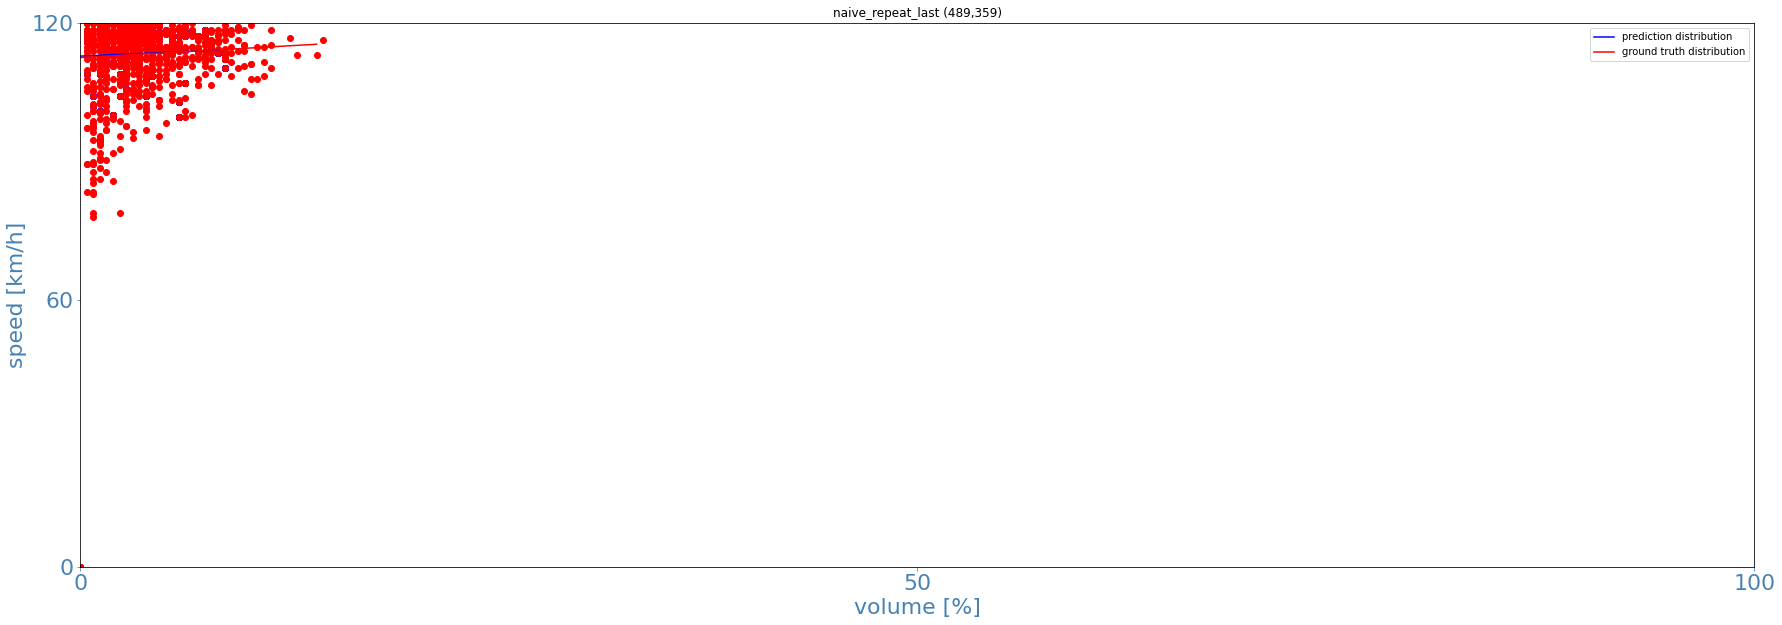

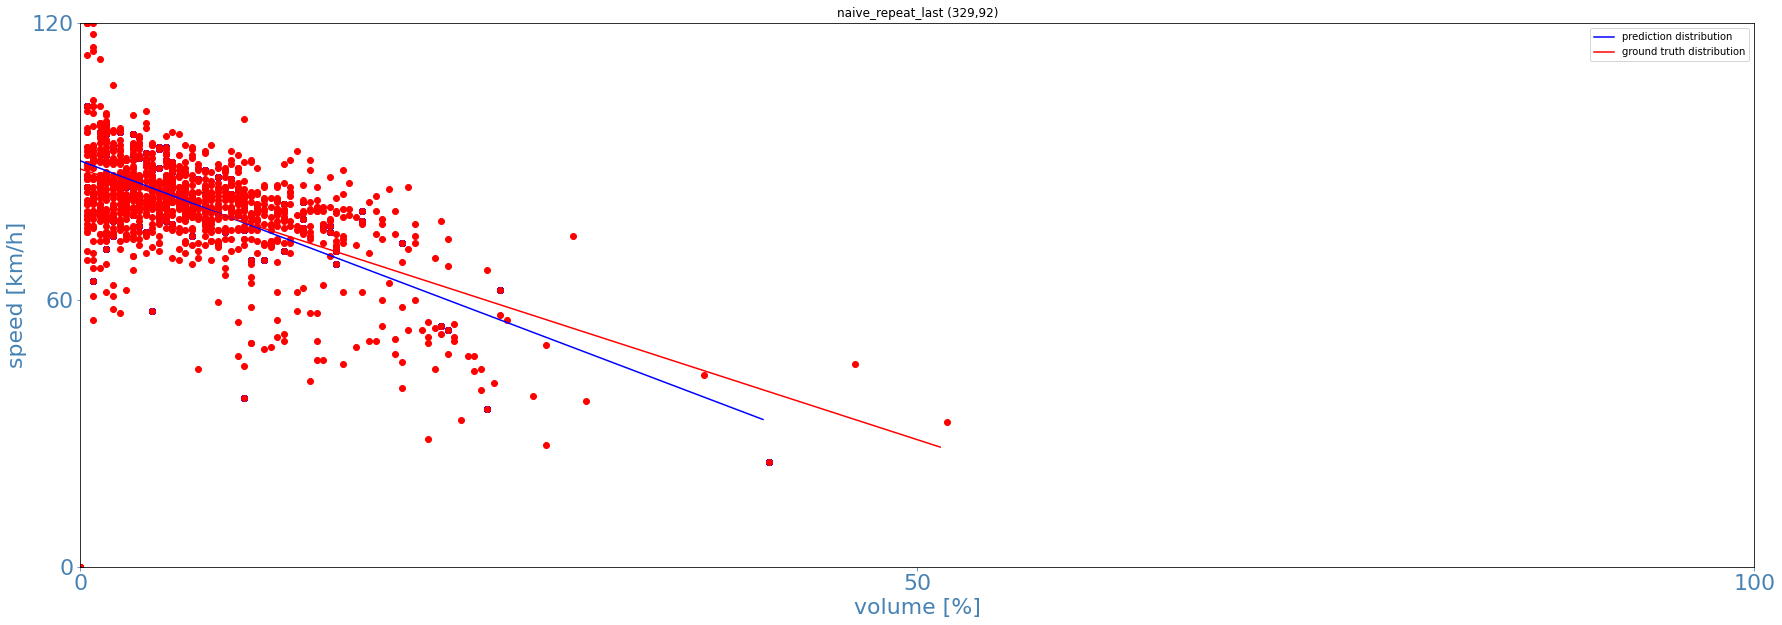

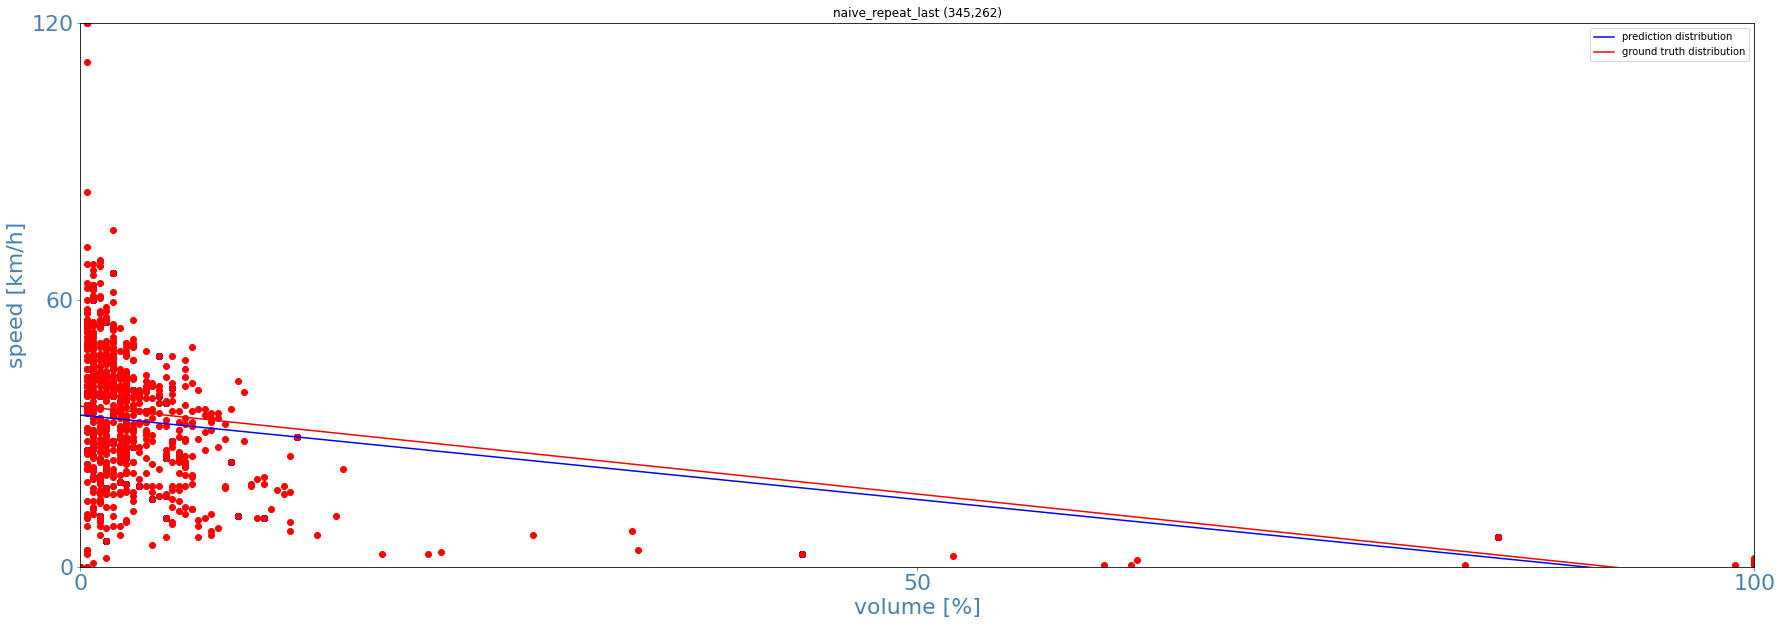

In [28]:
plot_fundamental_diagram_with_ground_truth(naive_repeat_last_prediction,test_slots, 489, 359, "naive_repeat_last")
plot_fundamental_diagram_with_ground_truth(naive_repeat_last_prediction,test_slots, 329, 92, "naive_repeat_last")
plot_fundamental_diagram_with_ground_truth(naive_repeat_last_prediction,test_slots, 345, 262, "naive_repeat_last")